# **Pre-Processing**

The dataset that I have been working with so far was only 10% of the original dataset. In this notebook I will run the full dataset through the same process that I used on the 10% version. I believe that with GPU friendly models I will be able to run the full dataset through the training process. If not I can revert back to the 10% version. 

The source of this data already had split the data into training and testing data. The purpose of this notebook is to prepare the full dataset and separate test set with the same process that I used in the data wrangling notebook. 

#### **Import Packages**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as im
from sklearn.preprocessing import StandardScaler

from tqdm import tqdm

import os

#### **Set Directory**

In [2]:
# Find and set the working directory for this project
os.chdir(r'C:\Users\jdrel\OneDrive\Documents\Data_Science\Springboard\Capstone-2')

####  **Load the Data**

In [3]:
# Import the data
train = pd.read_csv('./data/raw/Full.data.corrected')

# Import the test data
test = pd.read_csv('./data/raw/test')

# Load the columns of small_df
small_df = pd.read_csv('./data/interim/Small_df.csv')

# Load columns of big_df
big_df = pd.read_csv('./data/interim/Big_df.csv')


This next code cell I will delete when I re run the project again. I forgot to set index=False in to_csv so I have to drop the extra column. 

In [4]:
# Drop index I shouldn't have created
small_df = small_df.drop('Unnamed: 0', axis = 1)
# Drop index I shouldn't have created
big_df = big_df.drop('Unnamed: 0', axis = 1)

Now I create the function by copying all of the alterations that I made in the data Wrangling notebook and putting them here. I can return a working dataset that will be used in the modelling.

#### **Process Function**

In [8]:
def processing(dfx):
    # I copy and pasted the column names from the website into this list
    dfx.columns = ["duration", "protocol_type", "service", "flag", "src_bytes",
                    "dst_bytes", "land", "wrong_fragment", "urgent", "hot",
                    "num_failed_logins", "logged_in", "num_compromised",
                    "root_shell", "su_attempted", "num_root", "num_file_creations",
                    "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login",
                    "is_guest_login", "count", "srv_count", "serror_rate","srv_serror_rate",
                    "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate",
                    "dst_host_count", "dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate",
                    "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", "dst_host_serror_rate", 
                    "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "labels"]
    
    # Between 'num_outbound_cmds', and 'is_host_login' there are 2 non zero values both are observations that were both normal.
    # Use the drop methods to get rid of the near constants
    dfx = dfx.drop(columns = ['num_outbound_cmds', 'is_host_login'], axis = 1)
    '''
    Now we separate the data into the feature variables (X) and the target variable (y). With the features dataframe we can use 
    the pd.get_dummies function to create dummy features for all the categories in the categorical columns. This will make it possible 
    to analyze all the features for multicolinearity and then use lasso regularization to determine the most important features.
    '''
    # Only use the X data so that it is easy to test for multicolinearity
    X_data = dfx.drop('labels', axis = 1)

    # Find the categorical columns that need to be made numerical for analysis
    cat_cols = list(X_data.select_dtypes(include = 'object').columns)

    # Creating a completely numerical dataset that is usable for analysis
    X_data = pd.get_dummies(X_data, columns = cat_cols, 
                            # When testing for multi-co-linearity it is important to drop one of the dummies
                            # so that that column doesn't get flagged
                                drop_first = True)
    
    '''
    Skewed features are a problem as they make it hard for models to accurately describe interactions between different features because
    the arbitrary size of some feature will completely warp the math. To fix this we can scale the features with StandardScaler so as to
    preserve the nature of the feature without destroying the model by its size.
    '''
    # Create the scaler object
    scaler = StandardScaler()
    # fit the scaler to the dataset
    scaler.fit(X_data)
    # Scale the dataset
    X_data = pd.DataFrame(scaler.transform(X_data), columns = X_data.columns)

    '''
    Creating the features 'Syn Error' and 'Rej Error'
    '''
    # Define the Syn Error columns
    serror = ['serror_rate', 'srv_serror_rate', 'dst_host_serror_rate', 'dst_host_srv_serror_rate']

    # Define the Syn Error columns
    rerror = ['rerror_rate', 'srv_rerror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate']

    # Create new Syn Error column as mean of the former Syn Error columns
    X_data['Syn Error'] = X_data[serror].max(axis = 1)


    # Create new Syn Error column as mean of the former Syn Error columns
    X_data['Rej Error'] = X_data[rerror].max(axis = 1)


    # Drop the redundant columns
    X_data = X_data.drop(columns = [*serror, *rerror])
    
    '''
    get the list of the columns in big and small dataframe
    '''
    # Create the list of all the features that were in small_df
    small_features = list(small_df.columns)
    # Drop the target column 'labels' from that list
    small_features.remove('labels')
    # Create the list of all the features that were in big_df
    big_features = list(big_df.columns)
    # Drop the target column 'labels' from that list
    big_features.remove('labels')
 
    '''
    Now it is time to create the dataset
    '''
    # Generate the training dataframe for features that determine intrusion
    X_small = X_data[small_features]
    # Generate the training dataframe for features that determine type of intrusion
    X_big = X_data[big_features]
    # Save the variable in the workspace so that it can be used outside the function
    global small
    # Join X and y together for a complete dataset
    small = pd.concat([X_small, dfx['labels']], axis = 1)
    # Save the variable in the workspace so that it can be used outside the function
    global big
    # Join X and y together for a complete dataset
    big = pd.concat([X_big, dfx['labels']], axis = 1)

#### **Training Data**

In [9]:
# Run the processing function on the full training dataset
processing(train)
# Save the 12 feature version in a name with training
small_train = small
# Save the 61 feature version in a name with training
big_train = big

The test dataset contains a lot of new attack types that the models won't be able to predict exactly. For the model to give any insight on the type of intrusion that occured, I need to split up the attacks into different types and see if my model predicted an intrusion of the same type. 

I will bring up the messy chart that I had made in EDA to show the different types of intrusions.

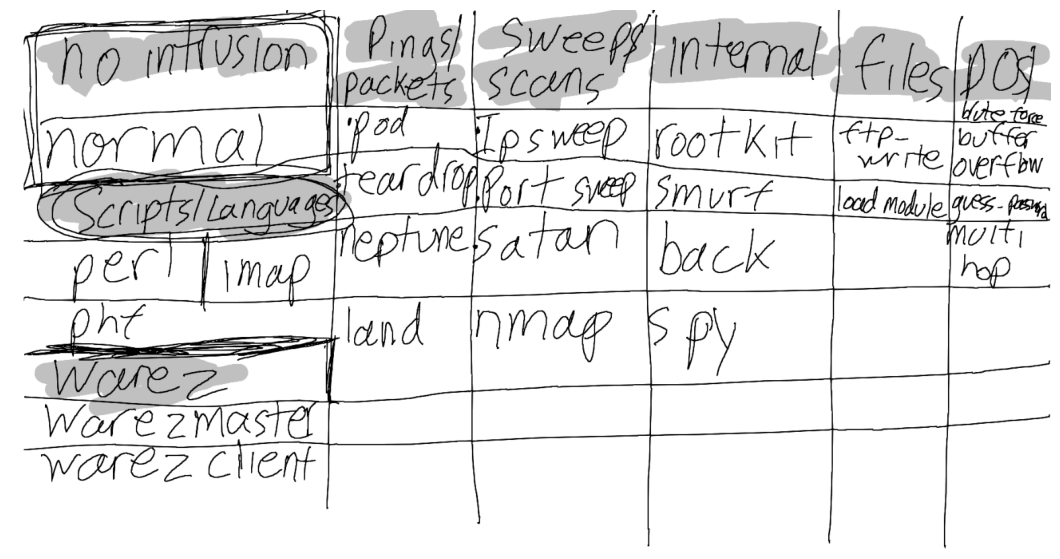

In [6]:
# Create the image object to be used
img = im.imread(r'./notebooks/Supernote/Potential Cluster Groupings.png');
# Create the plot that it will be shown on
fig, ax = plt.subplots(figsize=(25,7))
# Show the image
ax.imshow(img);
# Turn off axes and show just the image
ax.axis('off')
# Show the image.
plt.show();

Now we can create a grouping of the different intrusion types so that we have a way of generalizing future models to novel attack types

In [10]:
# Create a dictionary that binds the intrusion type to a list of all the intrusions that it pertains to
intrusion_groups = { 'none': 'normal.','pings':['pod.','teardrop.','neptune.', 'land.'], 'sweeps':['ipsweep.','portsweep.','satan.', 'nmap.'],
                    'internal':['rootkit.','smurf.', 'back.', 'spy.'], 'files':['ftp_write.', 'loadmodule.'], 
                    'brute force': ['buffer_overflow.', 'guess_passwd.', 'multihop.'], 'scripts': ['perl.', 'imap.', 'phf.'],
                    'warez': ['warezmaster.', 'warezclient.']}

# Create a loop for each index value in the intrusion column
for i in tqdm(range(small_train.shape[0])):
    # Create a loop that grabs the keys and values from each item in the dictionary 
    for k,v in intrusion_groups.items():
        # Determine if the intrusion type of the i index is in the item value's list
        if small_train.loc[i,'labels'] in v:
            # When it is, reassign the value to be the key which is the type of intrusion.
            small_train.loc[i,'group'] = k

100%|██████████| 4898430/4898430 [10:12<00:00, 7992.96it/s] 


In [11]:
# Use Value Counts to see if the grouping worked
small_train['group'].value_counts()

internal       2810101
pings          1073281
none            972780
sweeps           41102
warez             1040
brute force         90
scripts             19
files               17
Name: group, dtype: int64

Add the grouping to the big dataset since the the labels are the exact same.

In [20]:
# Since labels are the exact same in both I can use the same grouping
big_train = pd.concat([big_train, small_train['group']], axis = 1)

#### **Save the Data**

In [21]:
# Save the smaller training set with 12 features
small_train.to_csv('./data/processed/small_train.csv', index = False)

# Save the bigger training set with 61 features
big_train.to_csv('./data/processed/big_train.csv', index = False)

#### **Test Data**

In [12]:
# Run the processing function on the official test set that has new attack types
processing(test)
# Save small from the function in a variable that has test in it
small_test = small
# Save big from the function in a variable that has test in it
big_test = big

Now that we have the special test data I need to see the new attack types so that I can sort them into the groups that I have made. Below the code creates a bulleted list of all the new attack types so that it is easy to research them.

In [14]:
# Create a variable that has the set of new attacks that didn't occur in any of the training
new_attacks = set(small_test['labels'].unique()) - set(small_df['labels'].unique())
# Create a loop over all the different attack types
for type in new_attacks:
    # Print out the attack types in bullet format to make the next section easier
    print(f"- {type}")

- xsnoop.
- udpstorm.
- mscan.
- named.
- processtable.
- xlock.
- snmpgetattack.
- snmpguess.
- worm.
- ps.
- httptunnel.
- sendmail.
- saint.
- mailbomb.
- apache2.
- xterm.
- sqlattack.


Similar to the intrusion types in the training set I used chatgpt to give an explanation on all the new kind of attack types.

- **xsnoop:** A program that snoops on packets sent over a network, typically used for monitoring network traffic and data.
- **udpstorm:** A denial-of-service attack that floods a network with User Datagram Protocol (UDP) packets, overwhelming the network and causing it to crash or become unresponsive.
- **mscan:** A tool used for scanning a network for vulnerabilities and weaknesses, often used by hackers to find targets to exploit.
- **named:** A service that provides domain name resolution on a network, often targeted by hackers looking to gain unauthorized access or cause disruption.
- **processtable:** A denial-of-service attack that exploits vulnerabilities in the process table of a server or network device, causing it to crash or become unresponsive.
- **xlock:** A program that locks a user's terminal, requiring them to enter a password to regain access, often used as a security measure.
- **snmpgetattack:** A type of attack that exploits vulnerabilities in the Simple Network Management Protocol (SNMP), allowing an attacker to gain unauthorized access to network devices and sensitive information.
- **snmpguess:** A brute-force attack that attempts to guess the community string used by SNMP to gain unauthorized access to network devices and sensitive information.
- **worm:** A type of malware that self-replicates and spreads across a network, often causing damage or disruption to network operations.
- **ps:** A command used to display information about running processes on a system, often targeted by hackers looking to gain information or access to the system.
- **httptunnel:** A technique used to bypass firewalls and other security measures by encapsulating network traffic within HTTP requests and responses.
- **sendmail:** A mail transfer agent used to send and receive email messages, often targeted by hackers looking to gain unauthorized access or distribute spam.
- **saint:** A tool used for scanning a network for vulnerabilities and weaknesses, often used by system administrators to identify potential security issues.
- **mailbomb:** A type of attack that floods a user's inbox with a large volume of email messages, often causing the email server to crash or become unresponsive.
- **apache2:** A web server used to host and serve web pages, often targeted by hackers looking to gain unauthorized access or cause disruption.
- **xterm:** A terminal emulator used to access the command-line interface of a Unix-based operating system, often targeted by hackers looking to gain unauthorized access or execute commands on the system.
- **sqlattack:** A type of attack that exploits vulnerabilities in SQL databases, allowing an attacker to gain unauthorized access to sensitive information or execute malicious code.

Most of these fit my categories well but a couple I didn't have an answer for. If my model is able to detect them as attacks I will be happy. If it is able to give me attack type I will be surprised.

Once I determined the groupings of the new attacks I added them to the dictionary and repeate the process of creating a column that has the groupings. 

In [15]:
# Create a dictionary that has the new attack types
intrusion_groups = { 'none': 'normal.','pings':['pod.','teardrop.','neptune.', 'land.', 'mailbomb.'], 
                    'sweeps':['ipsweep.','portsweep.','satan.', 'nmap.', 'mscan.','saint.'],
                    'internal':['rootkit.','smurf.', 'back.', 'spy.', 'xlock.','xsnoop.','worm.'], 
                    'files':['ftp_write.', 'loadmodule.'], 
                    'brute force': ['buffer_overflow.', 'guess_passwd.', 'multihop.', 'udpstorm.', 'processtable.', 'snmpguess.'],
                    'scripts': ['perl.', 'imap.', 'phf.', 'named.', 'snmpgetattack.', 'ps.','xterm.','httptunnel.','sendmail.','apache2.', 'sqlattack.'],
                    'warez': ['warezmaster.', 'warezclient.']}

# Create a loop for each index value in the intrusion column
for i in tqdm(range(small_test.shape[0])):
    # Create a loop that grabs the keys and values from each item in the dictionary 
    for k,v in intrusion_groups.items():
        # Determine if the intrusion type of the i index is in the item value's list
        if small_test.loc[i,'labels'] in v:
            # When it is, reassign the value to be the key which is the type of intrusion.
            small_test.loc[i,'group'] = k        

100%|██████████| 311028/311028 [00:39<00:00, 7954.26it/s]


Same as the training data I can just copy and paste the groupings onto the bigger dataset.

In [22]:
# Since labels are the exact same in both I can use the same grouping
big_train = pd.concat([big_train, small_test['group']], axis = 1)

In [ ]:
# There can only be one target variable and it is groups
small_train = small_train.drop('labels', axis = 1)
big_train = big_train.drop('labels', axis = 1)

#### **Save the Data**

In [23]:
# Save the 12 feature test for future use 
small_test.to_csv('./data/processed/small_test.csv', index = False)

# Save the bigger test for future use
big_test.to_csv('./data/processed/big_test.csv', index = False)